# Определение возраста покупателей

**Описание проекта**

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
Контролировать добросовестность кассиров при продаже алкоголя.
Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

### Импортируем библиотеки

In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
import numpy as np
import warnings
warnings.filterwarnings('ignore')

### Создаем датафрейм

In [2]:
df = pd.read_csv('/kaggle/input/dataset/labels.csv')

In [3]:
df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


#### Смотрим на размер выборки

In [5]:
df.shape

(7591, 2)

### С помощью гистограмм построим графики распределения возраста в выборках

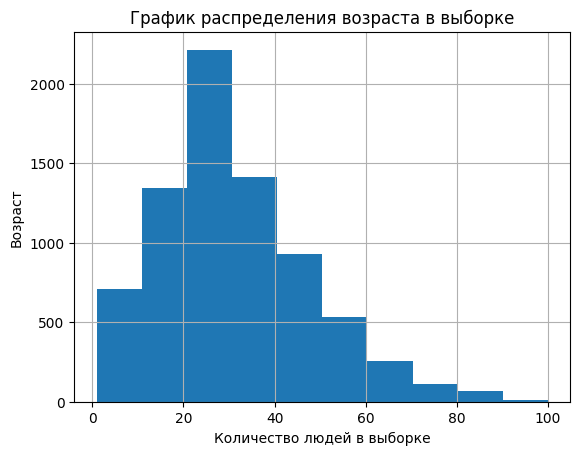

In [6]:
df['real_age'].hist();
plt.title('График распределения возраста в выборке');
plt.xlabel('Количество людей в выборке');
plt.ylabel('Возраст');

In [7]:
df_train, df_valid = train_test_split(df, test_size=0.25, random_state=12345)

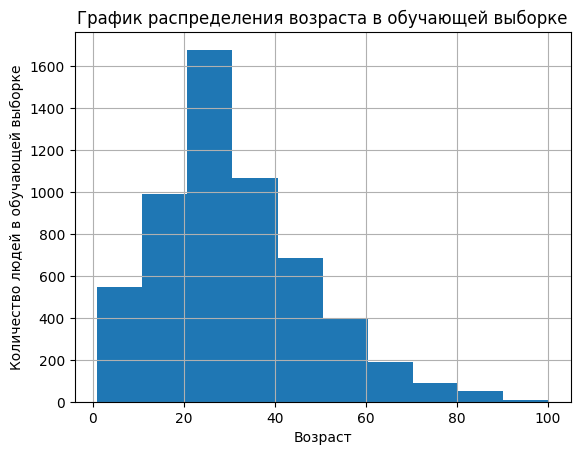

In [8]:
df_train['real_age'].hist();
plt.title('График распределения возраста в обучающей выборке');
plt.xlabel('Возраст');
plt.ylabel('Количество людей в обучающей выборке');

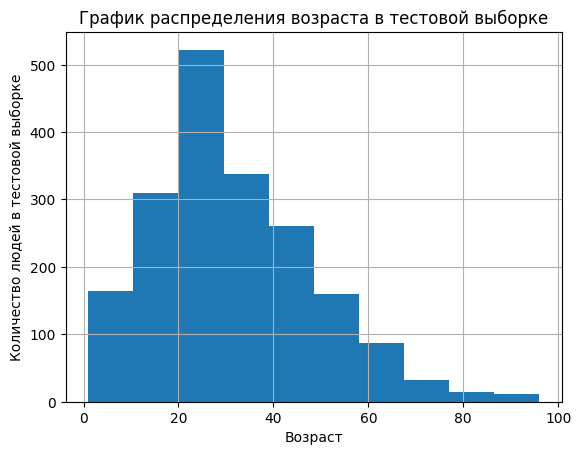

In [9]:
df_valid['real_age'].hist();
plt.title('График распределения возраста в тестовой выборке');
plt.xlabel('Возраст');
plt.ylabel('Количество людей в тестовой выборке');

### С помощью ImageDataGenerator создадим загрузчики изображений для обучающей и валидационной выборок.

In [10]:
path = '/kaggle/input/dataset/'

In [11]:
# На выборках добавим масштабирование яркости изображений rescale.
# Для изображений обучающей выборки добавим горизонтальный флип horizontal_flip (позволит увеличить обучающую выборку в два раза)
train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255, 
                                   horizontal_flip=True,
                                   zoom_range=0.2)
val_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)

In [12]:
# Загрузка изображений будет происходить батчами по 32 изображения.
def load_train_datagen(path):
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path+'labels.csv'),
        directory=path + 'final_files/' + 'final_files',
        x_col='file_name',
        y_col='real_age',
        class_mode='raw',
        target_size=(224, 224),
        batch_size=32,
        subset='training',
        seed=12345)
    return train_datagen_flow

In [13]:
train_datagen_flow = load_train_datagen(path)

Found 5694 validated image filenames.


In [14]:
def load_test_datagen(path):
    val_datagen_flow = val_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path+'labels.csv'), 
        directory=path + 'final_files/' + 'final_files',
        x_col='file_name',
        y_col='real_age',
        class_mode='raw',
        target_size=(224, 224),
        batch_size=32,
        subset='validation',
        seed=12345)
    return val_datagen_flow

In [15]:
val_datagen_flow = load_test_datagen(path)

Found 1897 validated image filenames.


### Выгрузим из загрузчика массивы целевого и остальных признаков. Посмотрим на распределение возраста в одном батче для обучающей и тестовой выборках.

In [16]:
features_train, target_train = next(train_datagen_flow)
features_test, target_test = next(val_datagen_flow)

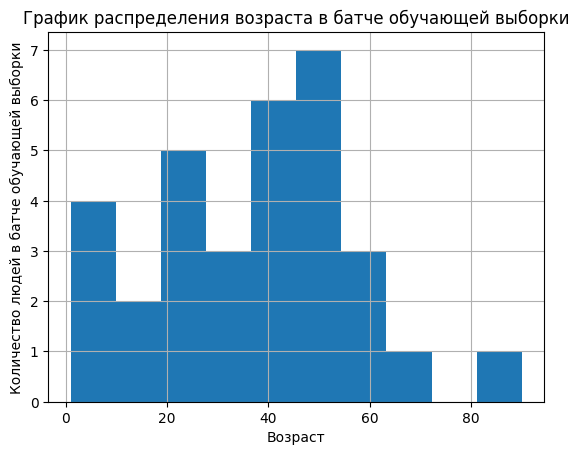

In [17]:
pd.Series(target_train).hist();
plt.title('График распределения возраста в батче обучающей выборки');
plt.xlabel('Возраст');
plt.ylabel('Количество людей в батче обучающей выборки');

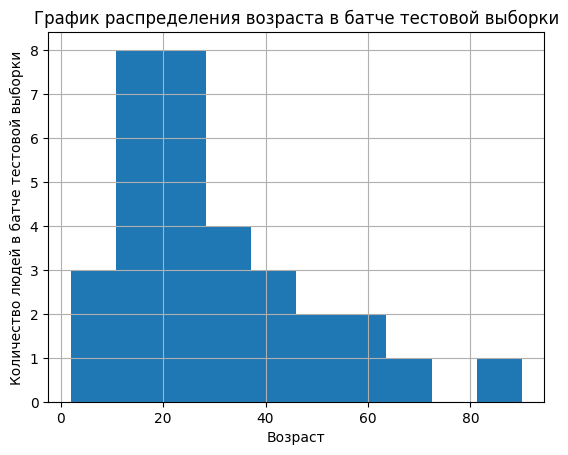

In [18]:
pd.Series(target_test).hist();
plt.title('График распределения возраста в батче тестовой выборки');
plt.xlabel('Возраст');
plt.ylabel('Количество людей в батче тестовой выборки');

### Напечатаем 15 фотографий из обучающей выборки. 

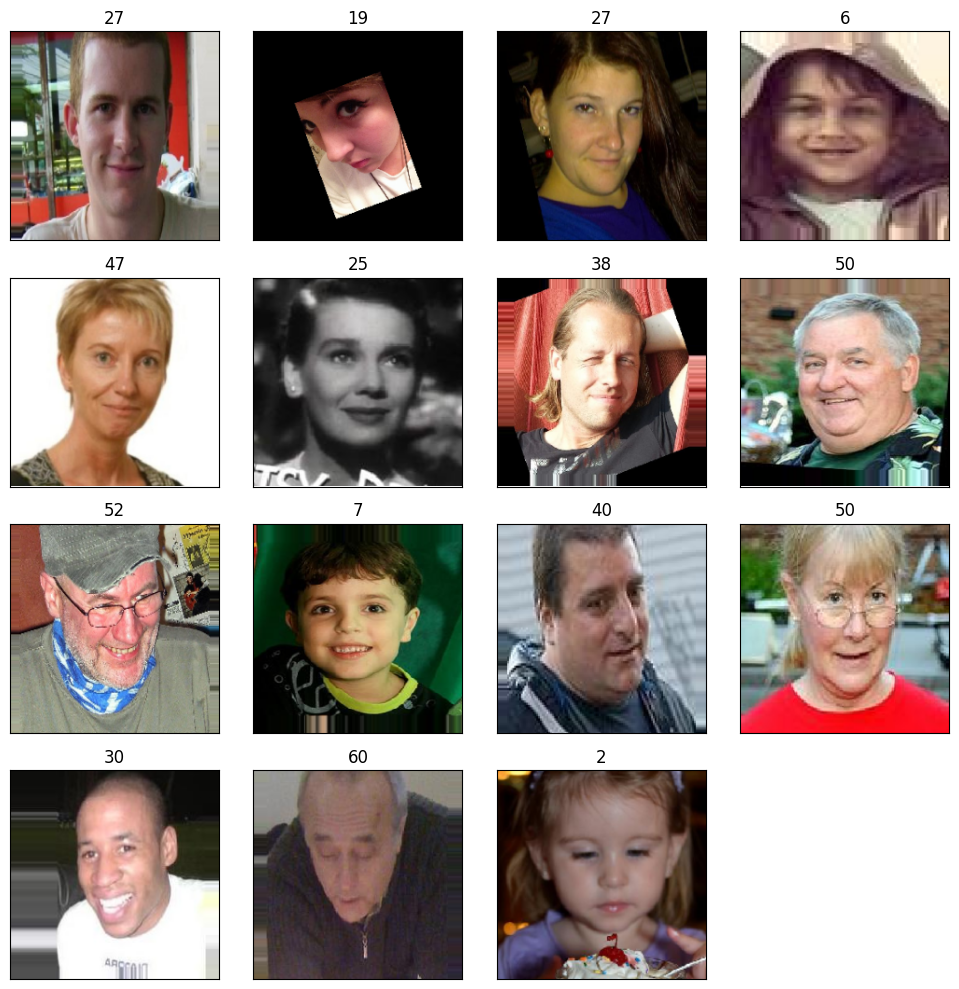

In [19]:
fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features_train[i])
    plt.title(target_train[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**В выборке преобладают изображения людей в возрасте 20-30 лет, поэтому вероятно модель будет распознавать возраст таких людей лучше, а людей в возрасте старше 60 хуже(из-за малого количества таких людей выборке).
На вход нейронной сети будет подаваться изображения c параметрами: 224х224 пикселей и 3 цветовыми каналами.**

## Обучение модели

### Построим модель на основе архитектуры RusNet50.

In [20]:
def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape, 
                        weights='imagenet', 
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    model.compile(loss='mae',
                  optimizer=tf.keras.optimizers.SGD(learning_rate=0.001), metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
    model.fit(train_data, 
              validation_data=test_data, 
              epochs=epochs, batch_size=batch_size,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model
    

In [21]:
model = create_model(input_shape=(224, 224, 3))

In [22]:
train_data = train_datagen_flow
test_data = val_datagen_flow

In [23]:
fit_model = train_model(model, train_data, test_data, batch_size=None, epochs=25,
                steps_per_epoch=None, validation_steps=None)

Epoch 1/25


I0000 00:00:1732881464.785582    4243 service.cc:145] XLA service 0x7b697c0035d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732881464.785661    4243 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1732881481.046802    4243 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


178/178 - 116s - 653ms/step - loss: 14.7840 - mae: 14.7840 - val_loss: 21.7511 - val_mae: 21.7511
Epoch 2/25
178/178 - 70s - 392ms/step - loss: 8.4548 - mae: 8.4548 - val_loss: 16.8823 - val_mae: 16.8823
Epoch 3/25
178/178 - 70s - 391ms/step - loss: 7.4154 - mae: 7.4154 - val_loss: 12.4875 - val_mae: 12.4875
Epoch 4/25
178/178 - 69s - 387ms/step - loss: 6.5749 - mae: 6.5749 - val_loss: 10.6226 - val_mae: 10.6226
Epoch 5/25
178/178 - 69s - 388ms/step - loss: 6.3537 - mae: 6.3537 - val_loss: 7.7759 - val_mae: 7.7759
Epoch 6/25
178/178 - 69s - 390ms/step - loss: 5.9902 - mae: 5.9902 - val_loss: 7.0537 - val_mae: 7.0537
Epoch 7/25
178/178 - 69s - 390ms/step - loss: 5.5319 - mae: 5.5319 - val_loss: 6.7961 - val_mae: 6.7961
Epoch 8/25
178/178 - 69s - 388ms/step - loss: 5.1979 - mae: 5.1979 - val_loss: 6.6050 - val_mae: 6.6050
Epoch 9/25
178/178 - 70s - 393ms/step - loss: 5.0331 - mae: 5.0331 - val_loss: 7.9168 - val_mae: 7.9168
Epoch 10/25
178/178 - 71s - 398ms/step - loss: 4.9205 - mae: 4.9

Сохраним обученную модель

In [24]:
fit_model.save("ex.h5")

### Объединим в один датафрейм предсказанный и реальный возраст.

In [25]:
predicted = fit_model.predict(features_test, verbose=0)
real_age = pd.DataFrame(target_test, columns=['Настоящий возраст'])
predicted_age = pd.DataFrame(round(pd.DataFrame(predicted, columns=['Предсказаный возраст'])).astype('int'))

real_age.merge(predicted_age, how='inner', left_index=True, right_index=True)

,Настоящий возраст,Предсказаный возраст
0,16,18
1,14,19
2,40,33
3,29,26
4,30,27
5,50,59
6,38,36
7,16,23
8,32,33
9,41,25


Посмотрим предсказанный возраст на фотографиях.

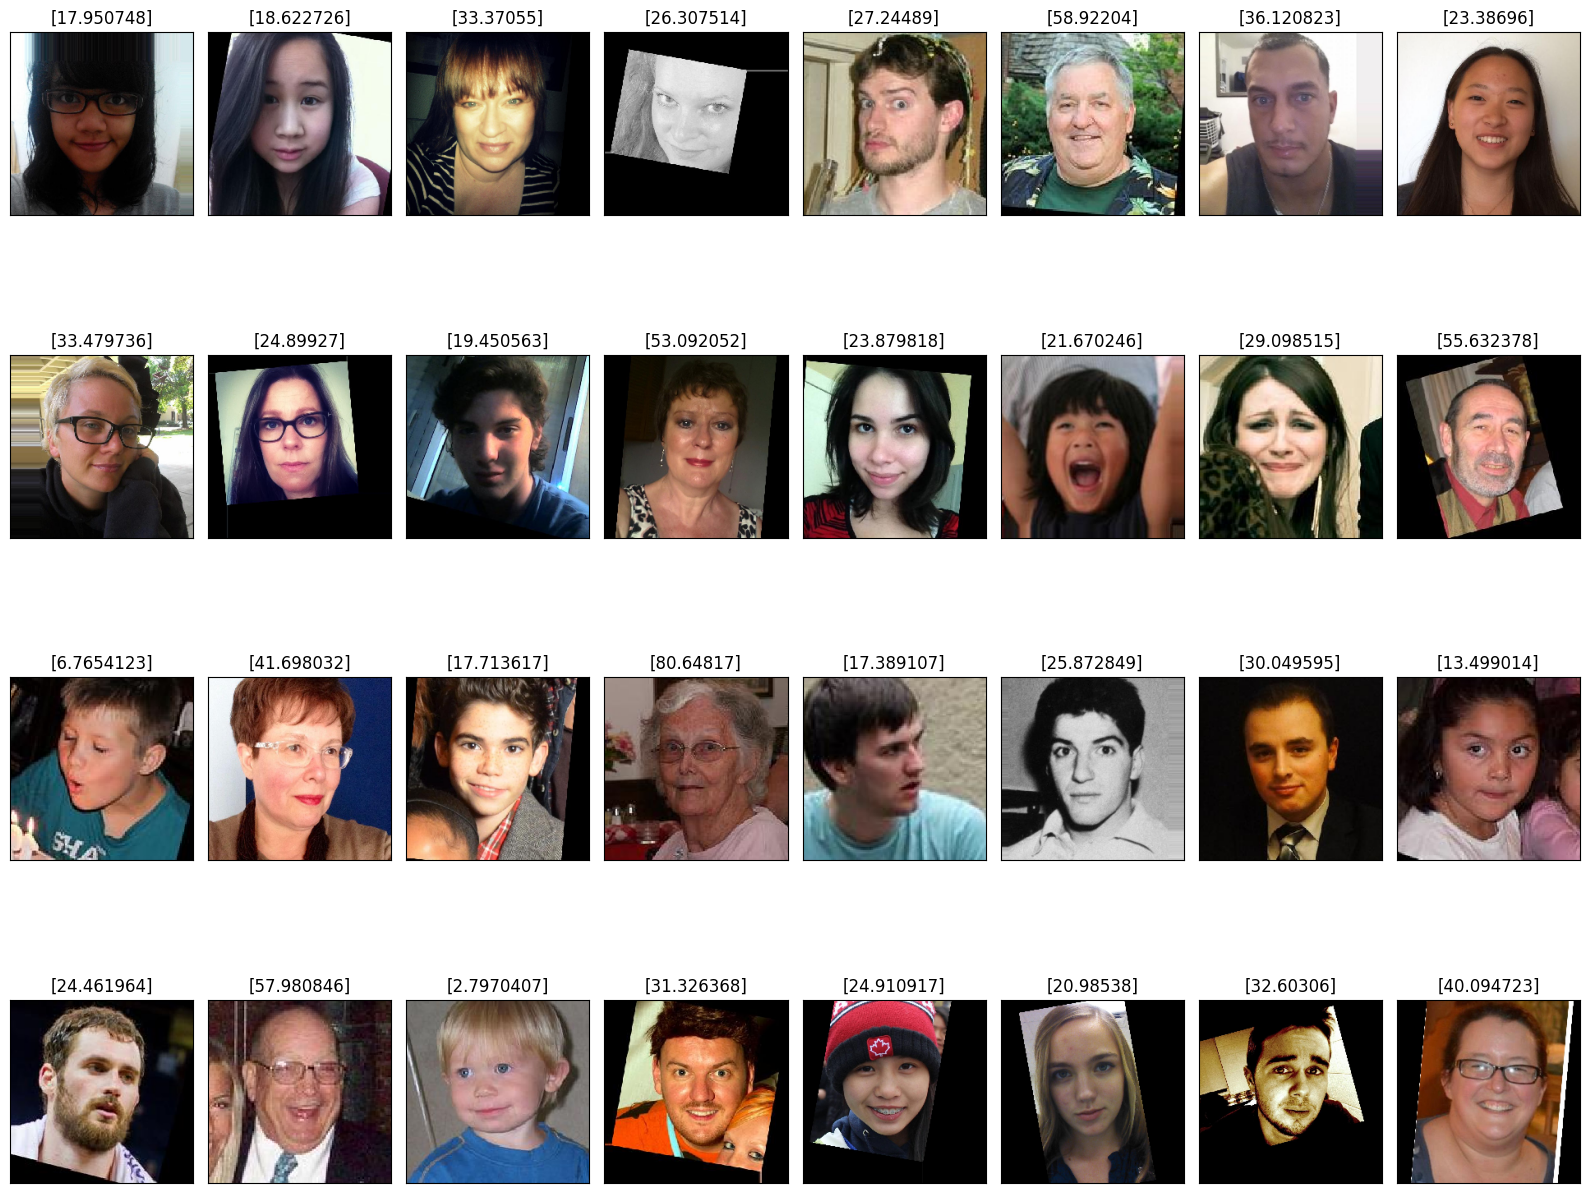

In [26]:
fig = plt.figure(figsize=(16,16))
for i in range(len(fit_model.predict(features_test, verbose=0))):
    fig.add_subplot(4, 8, i+1)
    plt.imshow(features_test[i])
    plt.title(f'{fit_model.predict(features_test, verbose=0)[i]}')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

## Анализ обученной модели

**Сверточная нейронная сеть была посторена на основе архетектуры ResNet50, c удалением последних 2 слоев и заменой последнего слоя на полносвязный слой с одним нейроном. Яркость изображений из обучающей выборки были приведены к диапазону [0, 1]. На обучающей выборке был добавлен горизонтальный флип. Веса модели ResNet50 инициализированные на датасете ImageNet были загружены с сервера. В качестве алгоритма обучения нейронной сети был выбран градиентный спуск (SGD). В качестве функции потерь была выбрана MAE. Средняя абсолютная ошибка (MAE) при обучении на 25 эпохах равна ~ 6.1 года.**